<a href="https://colab.research.google.com/github/toborobot/ED_solutions/blob/master/SoundDatasetCreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Создание датасета и модели аудиораспознавания из предварительно отобранных звуковых файлов (wav, 16000Hz, 2 sec)**

**Make environment** (устанавливаем все зависимости для создания модели)

In [ ]:
#для cp1
!pip install -U scikit-learn==0.21.3

In [ ]:
#для cp1
!pip install --timeout 100000000 openl3==0.2.0

In [ ]:
# не надо устанавливать tf1.14 - работает в версии v.2
#%tensorflow_version 1.x
#!pip uninstall tensorflow -y
#!pip install  tensorflow==1.14

In [ ]:
#нужно для openl3==0.2.0
!pip install kapre==0.1.4

In [ ]:
#проверяем пакеты
!pip freeze

Загружаем с Google Disk проверенные файлы, разбитые по директориям - классам.


In [4]:
%cd /content
%mkdir data
%cd /content/data

# link of dataset example file downloaded to You Google Drive folder
fileId = '----' #https://drive.google.com/file/d/----/view?usp=sharing
import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/content
/content/data
Extracted zip file 1pSckIz8xBqO71zZputSi_yx0-HCb84Z4.zip


**Make new detector**

In [ ]:
#удаляем если что-то пошло криво
%cd /content/data
!rm -rf test4class_model

In [5]:
#создаем структуру каталогов
!mkdir test4class_model #name of detector
%cd test4class_model
!mkdir data
!mkdir features
%cd /content/data

/content/data/test4class_model
/content/data


**Prepare data folder and csv file**

In [10]:
import os
import csv
from shutil import copyfile
import random

# select target classes for new model
target_classes = ["Cough","Speech","Applause","GunshotGunfire"]
model_name = "test4class_model"

csv_file_array = []
for target_class in target_classes:
  if not os.path.isdir("./dataset/"+target_class):
    print("Check name of delected class - "+ target_class)
    break
  for file_name in os.listdir("./dataset/"+target_class):
    csv_file_array.append([file_name,target_class])
    copyfile("./dataset/"+target_class+"/"+file_name, "./"+model_name+"/data/"+file_name)

#shuffle array
random.shuffle(csv_file_array)

# make csv file
with open("./"+model_name+"/train.csv", 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["name", "label"])
  for csv_file_record in csv_file_array:
    writer.writerow(csv_file_record)

**Preparing features and model**

In [ ]:
%cd /content/data

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.io.wavfile import read
import pandas as pd
import os
import pickle
import openl3
import numpy as np

In [ ]:
emb_model = openl3.models.load_embedding_model(input_repr="mel256", content_type="music", embedding_size=512)

def calc_feature(file_path, feature_path):
    file_name = file_path.split('/')[-1]
    feature_name = file_name.split('.')[0] + '.pickle'
    if os.path.isfile(os.path.join(feature_path, feature_name)):
        print('already exist', feature_name)
        with open(os.path.join(feature_path, feature_name), 'rb') as f:
            feature = pickle.load(f)
    else:
        sr, wav = read(file_path)
        if len(wav) == 0:
            wav = np.zeros(16000)
        emb, ts = openl3.get_embedding(wav, sr, emb_model, hop_size=1, center=False)
        feature = emb.mean(axis=0)
        with open(os.path.join(feature_path, feature_name), 'wb') as f:
            pickle.dump(feature, f)
        #os.remove(file_path)
    return feature


presets = ['test4class_model']
model_count = 5

for preset in presets:
    meta_train = pd.read_csv(os.path.join(preset, 'train.csv'))
    feat_path = os.path.join(preset, 'features')
    x = []
    for fname in meta_train['name']:
        print(fname)
        fpath = os.path.join(preset, 'data', fname)
        x.append(calc_feature(fpath, feat_path))
    x = np.array(x)
    y = np.array(meta_train['label'])
    models = []
    try:
        folder = KFold(n_splits=model_count)
        x_test = []
        y_test = []
        for train, test in folder.split(y):
            loc_features = [x[i] for i in train]
            loc_targ = [y[i] for i in train]
            x_test.append([x[i] for i in test])
            y_test.append([y[i] for i in test])
            models.append(LogisticRegression(solver='liblinear', multi_class='auto', max_iter=10000).fit(loc_features, loc_targ))
            #models.append(LogisticRegression().fit(loc_features, loc_targ))
            #print(models)
        with open(os.path.join(preset, model_name+'.pickle'), 'wb') as f:
            pickle.dump(models, f)
    except:
        continue

In [21]:
model_path = "/content/data/test4class_model"

# Load from file
with open(os.path.join(model_path, "test4class_model.pickle"), 'rb') as f:
    pickle_models = pickle.load(f)

#Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.3, random_state=4)    

# Calculate the accuracy score and predict target values
i = 0
score_average = 0
for pickle_model in pickle_models:
    #score = pickle_model.score(Xtest, Ytest)
    score = pickle_model.score(x_test[i], y_test[i])
    score_average = score_average + score
    i = i + 1
    print("Test score: {0:.2f} %".format(100 * score))
    #Ypredict = pickle_model.predict(Xtest)

print("Test average score: {0:.2f} %".format(100 * score_average / i))

Test score: 95.39 %
Test score: 97.35 %
Test score: 94.04 %
Test score: 96.03 %
Test score: 92.72 %
Test average score: 95.11 %


Архивируем полученную модель

In [ ]:
%cd /content/data/
!zip -r test4class_model test4class_model

In [9]:
#подключаем диск для сохранения модели и файлов
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive












**Визуализация (Дополнительно)**

In [ ]:
import tarfile, shutil
import zipfile
import sys, os, urllib.request, tarfile, glob
import numpy as np
import cv2
import librosa
import librosa.core
import librosa.feature
import librosa.display
import matplotlib.pyplot as plt

# wav file Input
def file_load(wav_name, mono=False):
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))

def make_data(folder_name, id_name):
    result = []
    all_name = glob.glob(folder_name)
    for name in all_name:
        if id_name in name:
            result.append(file_load(name)[0])
    return np.array(result)
    
# change wave data to stft
def to_sp(x, n_fft=512, hop_length=256):
    stft = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
    sp = librosa.amplitude_to_db(np.abs(stft))
    return sp

def to_img(x):
    result = []
    for i in range(len(x)):
        result.append(cv2.resize(to_sp(x[i]), (224,224)))
    return np.array(result)

In [ ]:
%cd /content/data

x_train = make_data("./dataset/Cough/*", "_")

#check max and min
print(np.max(x_train))
print(np.min(x_train))
print(np.mean(x_train))


/content/data
0.9999695
-1.0
-0.00027228164


In [ ]:
# data normalization not used now
max_ = 0.9999695 #np.max(x_train)
min_ = -1.0 #np.min(x_train)

X_train = (to_img(x_train)-min_)/(max_-min_)

mean = 133.4
sigma = 31.595366

#X_train = (X_train*255-mean)/sigma

print(np.mean(X_train), np.std(X_train))

X_train = np.expand_dims(X_train, axis=-1)

print(X_train.shape)

-13.585657 9.05006
(158, 224, 224, 1)


**Generate anomaly sound**

In [ ]:
import random
import pandas as pd

# add white noise
def add_whitenoise(x, rate=0.002):
    return to_sp(x + rate*np.random.randn(len(x)))

# add pink noise
# https://www.dsprelated.com/showarticle/908.php
def add_pinknoise(x, ncols=11, alpha=0.002):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    nrows = len(x)
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return to_sp(alpha * total.values + x)
# add random line
def draw_line(x, length=[5,20], thickness_length=[2,4]):
    result = np.copy(x)
    width = x.shape[1]
    height = x.shape[0]
    angle = [0, np.pi/2, np.pi, np.pi*3/2]
    np.random.shuffle(angle)

    length = np.random.randint(length[0],length[1])
    x1 = random.randint(length, width-length)
    x2 = x1 + length*np.cos(angle[0])
    y1 = random.randint(length, height-length)
    y2 = y1 + length*np.sin(angle[0])

    thickness = random.randint(thickness_length[0], thickness_length[1])
    color1 = float(np.max(x))

    cv2.line(result, (x1,y1), (int(np.min([width,x2])),int(np.min([height,y2]))), color1, thickness)

    return result

# change Hz to average
def average_Hz(x, length=[2,4]):
    result = np.copy(x)
    height = x.shape[0]

    length = np.random.randint(length[0],length[1])
    begin = np.random.randint(0, height-length)
    for i in range(length):
        result[begin+i] = np.mean(result[begin+i])

    return result

def normalization(x):
    max_ = 0.9999695#np.max(x_train)
    min_ = -1.0#np.min(x_train)
    mean = 133.4
    sigma = 31.595366

    result = cv2.resize(x, (224, 224))
    result = (result-min_)/(max_-min_)
    return (result*255-mean)/sigma

def to_img2(x):
    result = cv2.resize(to_sp(x), (224,224))
    return np.array(result)    

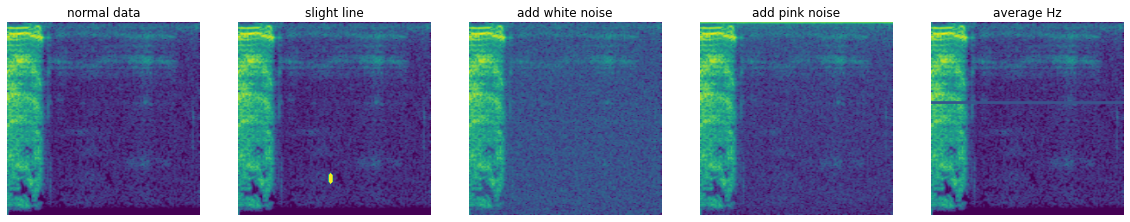

In [ ]:
target = np.copy(x_train[1])

img0 = to_img2(target)
img0 = normalization(img0)

img1 = draw_line(img0)

img2 = add_whitenoise(target)
img2 = normalization(img2)

img3 = add_pinknoise(target)
img3 = normalization(img3)

img4 = average_Hz(img0)

plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
plt.axis("off")
plt.title("normal data")
plt.imshow(img0)

plt.subplot(1,5,2)
plt.axis("off")
plt.title("slight line")
plt.imshow(img1)

plt.subplot(1,5,3)
plt.axis("off")
plt.title("add white noise")
plt.imshow(img2)

plt.subplot(1,5,4)
plt.axis("off")
plt.title("add pink noise")
plt.imshow(img3)

plt.subplot(1,5,5)
plt.axis("off")
plt.title("average Hz")
plt.imshow(img4)
plt.show()

***Data Augmentation***

In [ ]:
%cd /content/data/

import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

/content/data


In [ ]:
def load_audio_file(file_path):
    input_length = 32000
    data = librosa.core.load(file_path)[0] #, sr=32000
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
    return data
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

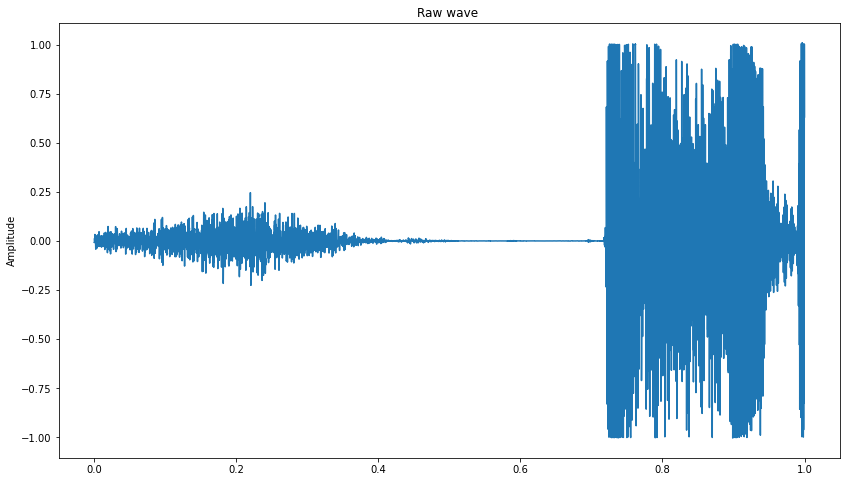

In [ ]:
data = load_audio_file("/content/data/dataset/Cough/2I2IzXnhmtc_2.wav")
plot_time_series(data)

In [ ]:
ipd.Audio(data, rate=16000)

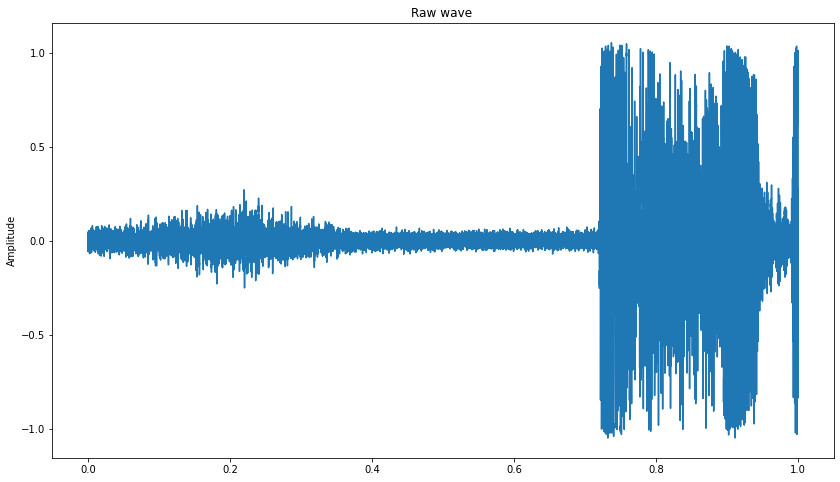

In [ ]:
# Adding white noise 
wn = np.random.randn(len(data))
data_wn = data + 0.02*wn
plot_time_series(data_wn)
# We limited the amplitude of the noise so we can still hear the word even with the noise, 
#which is the objective
ipd.Audio(data_wn, rate=16000)

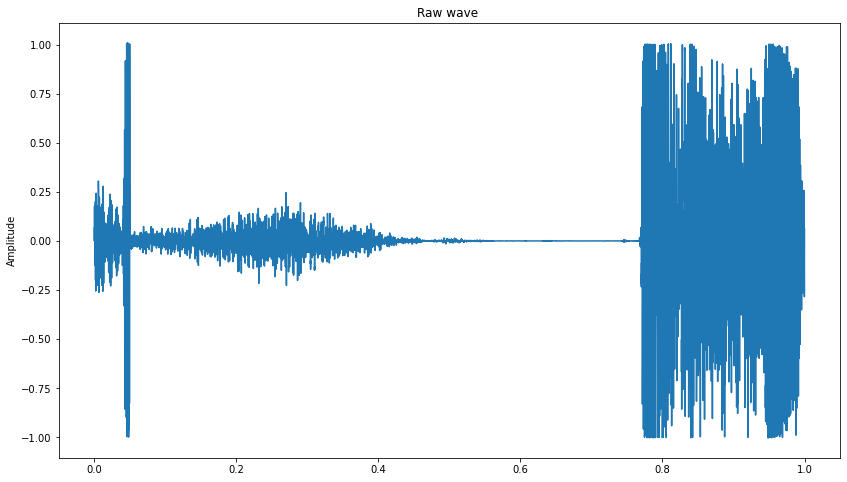

In [ ]:
# Shifting the sound
data_roll = np.roll(data, 1600)
plot_time_series(data_roll)
ipd.Audio(data_roll, rate=16000)

This makes the sound deeper


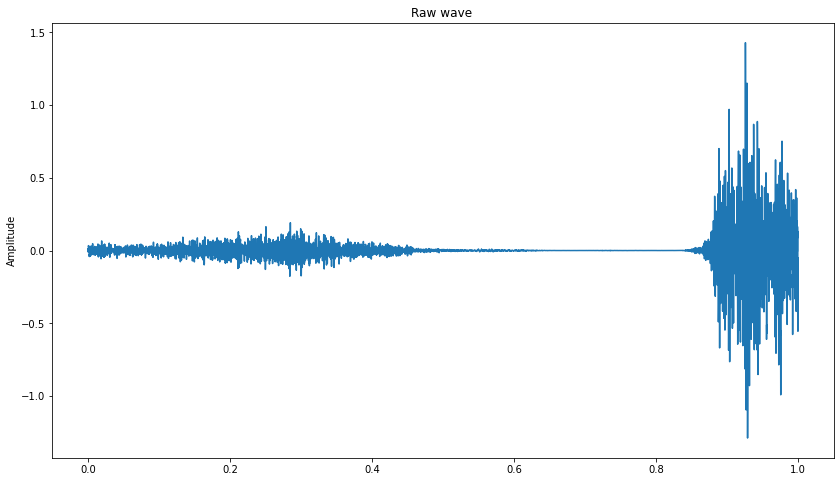

In [ ]:
# stretching the sound
def stretch(data, rate=1):
    input_length = 32000
    data = librosa.effects.time_stretch(data, rate)
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")

    return data

data_stretch =stretch(data, 0.8)
print("This makes the sound deeper")
plot_time_series(data_stretch)
ipd.Audio(data_stretch, rate=16000)


Higher frequencies  


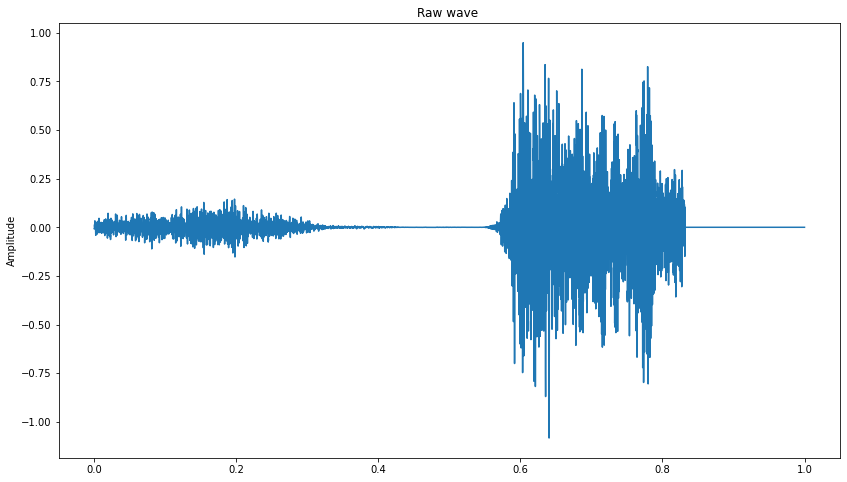

In [ ]:
data_stretch =stretch(data, 1.2)
print("Higher frequencies  ")
plot_time_series(data_stretch)
ipd.Audio(data_stretch, rate=16000)

Mix background noise & volume tuning

In [ ]:
%cd /content/data/

import os

bg_files = os.listdir('./dataset/GunshotGunfire/')
chosen_bg_file = bg_files[np.random.randint(100)]
bg, sr = librosa.load('./dataset/GunshotGunfire/'+chosen_bg_file, sr=None)
print(chosen_bg_file,'|', bg.shape[0], bg.max(), bg.min())
ipd.Audio(bg, rate=sr)

/content/data
GYOHFaVFp3o_5.wav | 32000 0.9999695 -0.9418335


In [ ]:
file_path = '/content/data/dataset/Cough/1PajbAKd8Kg_7.wav'
wav, sr = librosa.load(file_path, sr=None)
print(wav.shape, wav.max(), wav.min())

(32000,) 0.30593872 -0.31661987


In [ ]:
ipd.Audio(wav, rate=sr)

spectrogram shape: (257, 126)


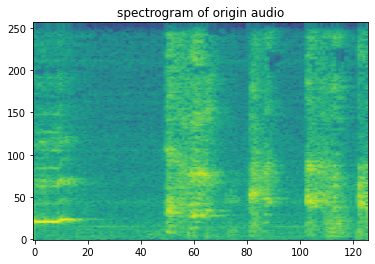

In [ ]:
def get_spectrogram(wav):
    D = librosa.stft(wav, n_fft=512, hop_length=256,
                     win_length=512, window='hamming')
    spect, phase = librosa.magphase(D)
    return spect

log_spect = np.log(get_spectrogram(wav))
print('spectrogram shape:', log_spect.shape)
plt.imshow(log_spect, aspect='auto', origin='lower',)
plt.title('spectrogram of origin audio')
plt.show()

In [ ]:
#start_ = np.random.randint(bg.shape[0]-32000)
start_ = 0
bg_slice = bg[start_ : start_+32000]
wav_with_bg = wav * np.random.uniform(0.8, 1.2) + \
              bg_slice * np.random.uniform(0, 0.3)
ipd.Audio(wav_with_bg, rate=sr) 

spectrogram shape: (257, 126)


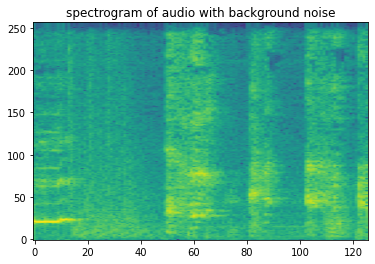

In [ ]:
log_spect = np.log(get_spectrogram(wav_with_bg)+1e-8)
print('spectrogram shape:', log_spect.shape)
plt.imshow(log_spect, aspect='auto', origin='lower',)
plt.title('spectrogram of audio with background noise')
plt.show()

In [ ]:
%cd /content/data/

from scipy.io.wavfile import write
write("new_sound.wav", sr, wav_with_bg)

/content/data
